Figures 10 and 12a were made with this 

# Solving a SOLA problem using the Problem class

The Problem class in the SOLA_DLI file contains all the tools for solving a SOLA problem within the "property bounds perspective". We start as usual by importing the needed packages

In [1]:
from sola.main_classes import domains
from sola.main_classes import spaces
from sola.aux.normal_data import load_normal_data
from sola.main_classes import functions
from sola.main_classes import mappings
from sola.main_classes.SOLA_DLI import Problem

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines


Before even attempting to SOLVE a SOLA problem we must first define the mappings and spaces that we will work in. We will build these mathematical components one by one starting with the model space. 

The lines of codes in the "Edit regions" can be modified to explore variations of the given default SOLA problem.

In [2]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['vs', 'vp', 'rho']

# Edit region -------------

physical_parameters_symbols = {'vs': '$\delta lnv_s$', 'vp': '$\delta lnv_p$', 'rho': '$\delta ln \\rho$'}
no_of_params = len(physical_parameters)
EarthDomain = domains.HyperParalelipiped(bounds=[[0, 6371]], fineness=1000)
constituent_models_spaces = [spaces.PCb(domain=EarthDomain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = spaces.DirectSumSpace(tuple(constituent_models_spaces))

Then the data space. This is also where we iport the sensitivity kernels.

In [3]:
###################
# Create Data space
###################
# Edit region -------------
data_directory = '../kernels_modeplotaat_Adrian'
which_data = list(np.arange(0, 143))
# Edit region -------------

# Import sensitivity data
how_many_data = len(which_data)
raw_sensitivity_dict = {}
raw_sensitivity_domains_dict = {}
for param in physical_parameters:
    raw_sensitivity_domain, raw_sensitivity = load_normal_data(param, data_directory)
    raw_sensitivity_dict[param] = np.array(raw_sensitivity)[which_data]
    if param not in raw_sensitivity_domains_dict:
        raw_sensitivity_domains_dict[param] = raw_sensitivity_domain
D = spaces.RN(dimension=how_many_data)

The the model-data mapping.

In [4]:
###########################
# Create model-data mapping
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for param in physical_parameters:
    sensitivity_dict[param] = []
    for discrete_sensitivity_kernel in raw_sensitivity_dict[param]:
        sensitivity_dict[param].append(functions.Interpolation_1D(values=discrete_sensitivity_kernel,
                                                                raw_domain=raw_sensitivity_domains_dict[param],
                                                                domain=EarthDomain))
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=D,
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = mappings.DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

In [5]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
chosen_target = functions.Gaussian_1D
target_types = {'vs': functions.Null_1D,
                'vp': chosen_target,
                'rho': functions.Null_1D}
width = 1000 # same units as domain (km here)
how_many_targets = 100
enquiry_points = np.linspace(EarthDomain.bounds[0][0],
                             EarthDomain.bounds[0][1],
                             how_many_targets)
# Edit region -------------
P = spaces.RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == chosen_target: # MODIFY HERE THE SPECIAL TARGET AS WELL!!!!
            targets_dict[param].append(target_type(domain=EarthDomain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else:
            targets_dict[param].append(target_type(domain=EarthDomain))
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=P,
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = mappings.DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

In [6]:
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

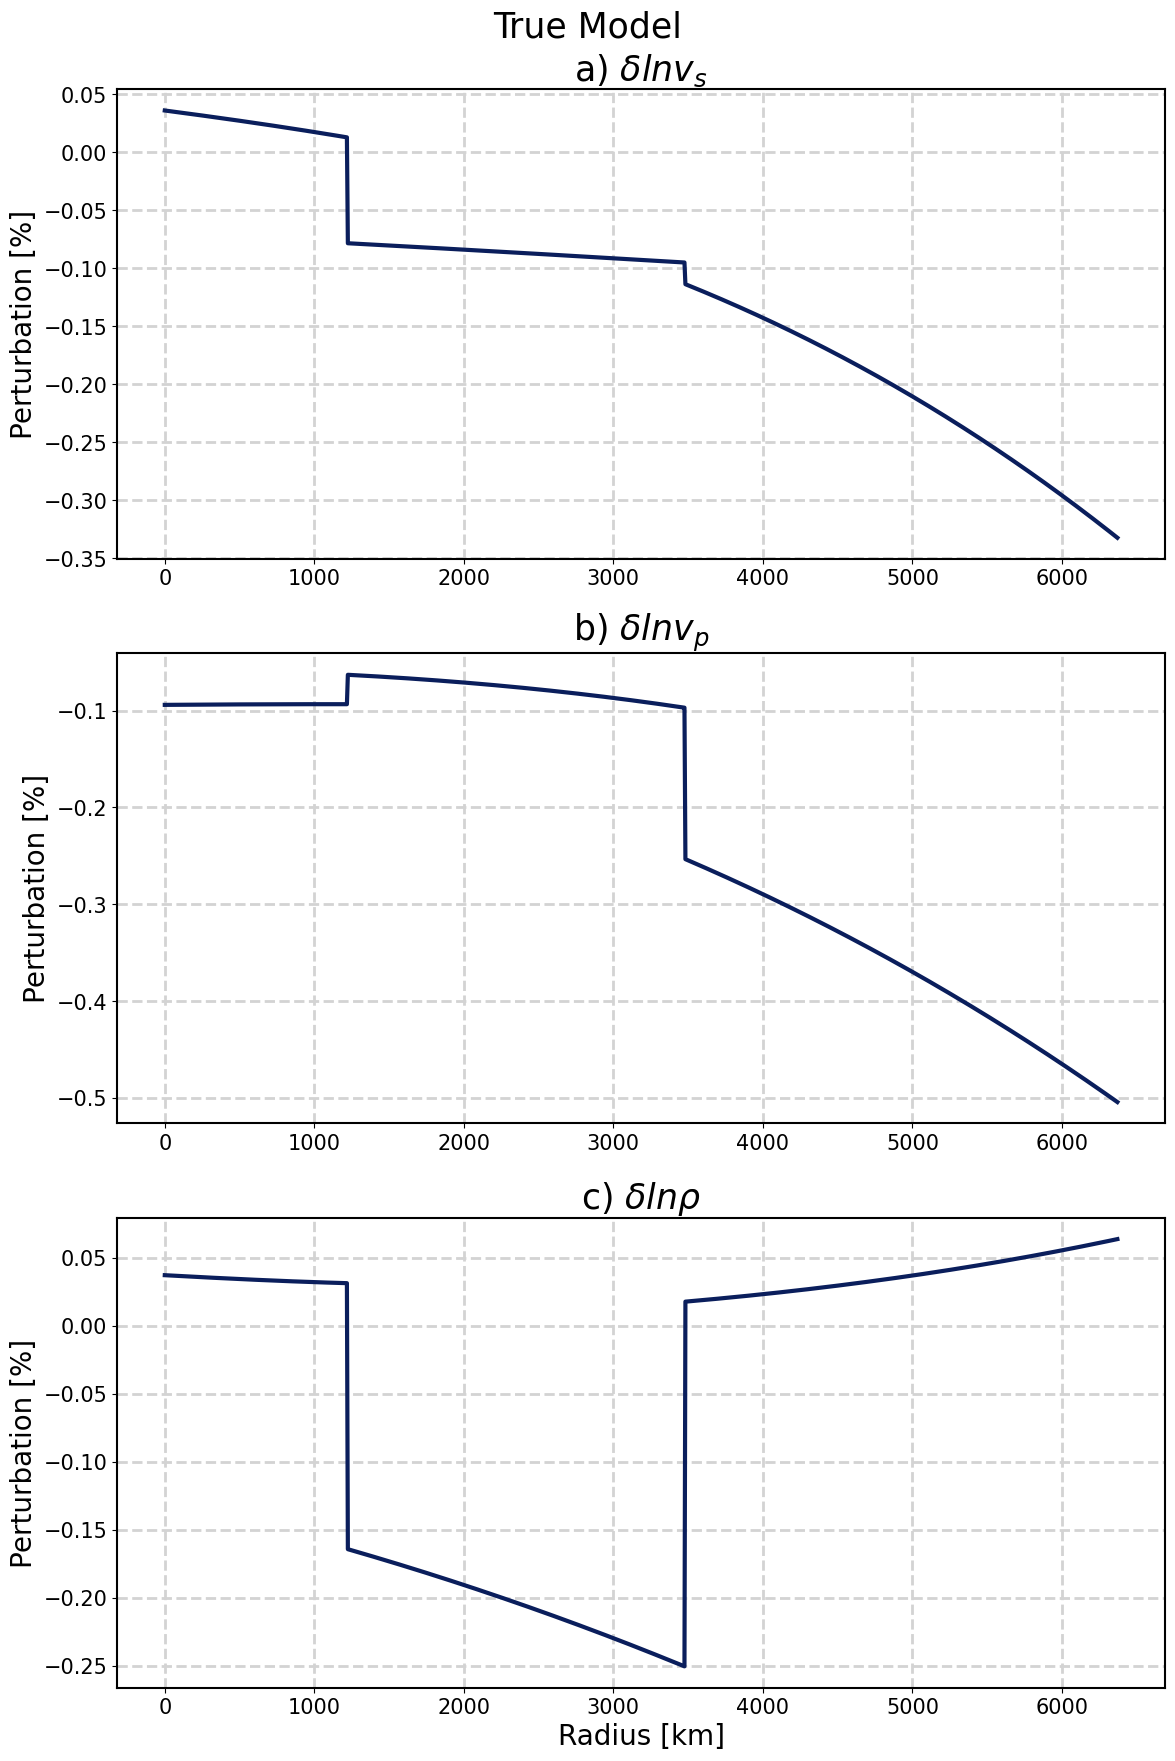

In [7]:
%matplotlib inline
#################################
# Create fake true model and data
#################################
boundaries = [1220, 3480]
true_model = M.random_member(args_list=[(1, False, boundaries),
                                        (2, False, boundaries),
                                        (3, False, boundaries)])
data = G.map(true_model)

labels = ['a) ', 'b) ', 'c) ']
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(EarthDomain.mesh, submodel.evaluate(EarthDomain.mesh),
            label='True Model', color=colors[99], linewidth=3)
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=25)
    axes[i].set_ylabel('Perturbation [%]', fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].grid(True, linestyle='--', linewidth=2, color='lightgray')  # Add gridlines
plt.xlabel('Radius [km]', fontsize=20)
plt.suptitle('True Model', fontsize=25)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth_normal.pdf', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

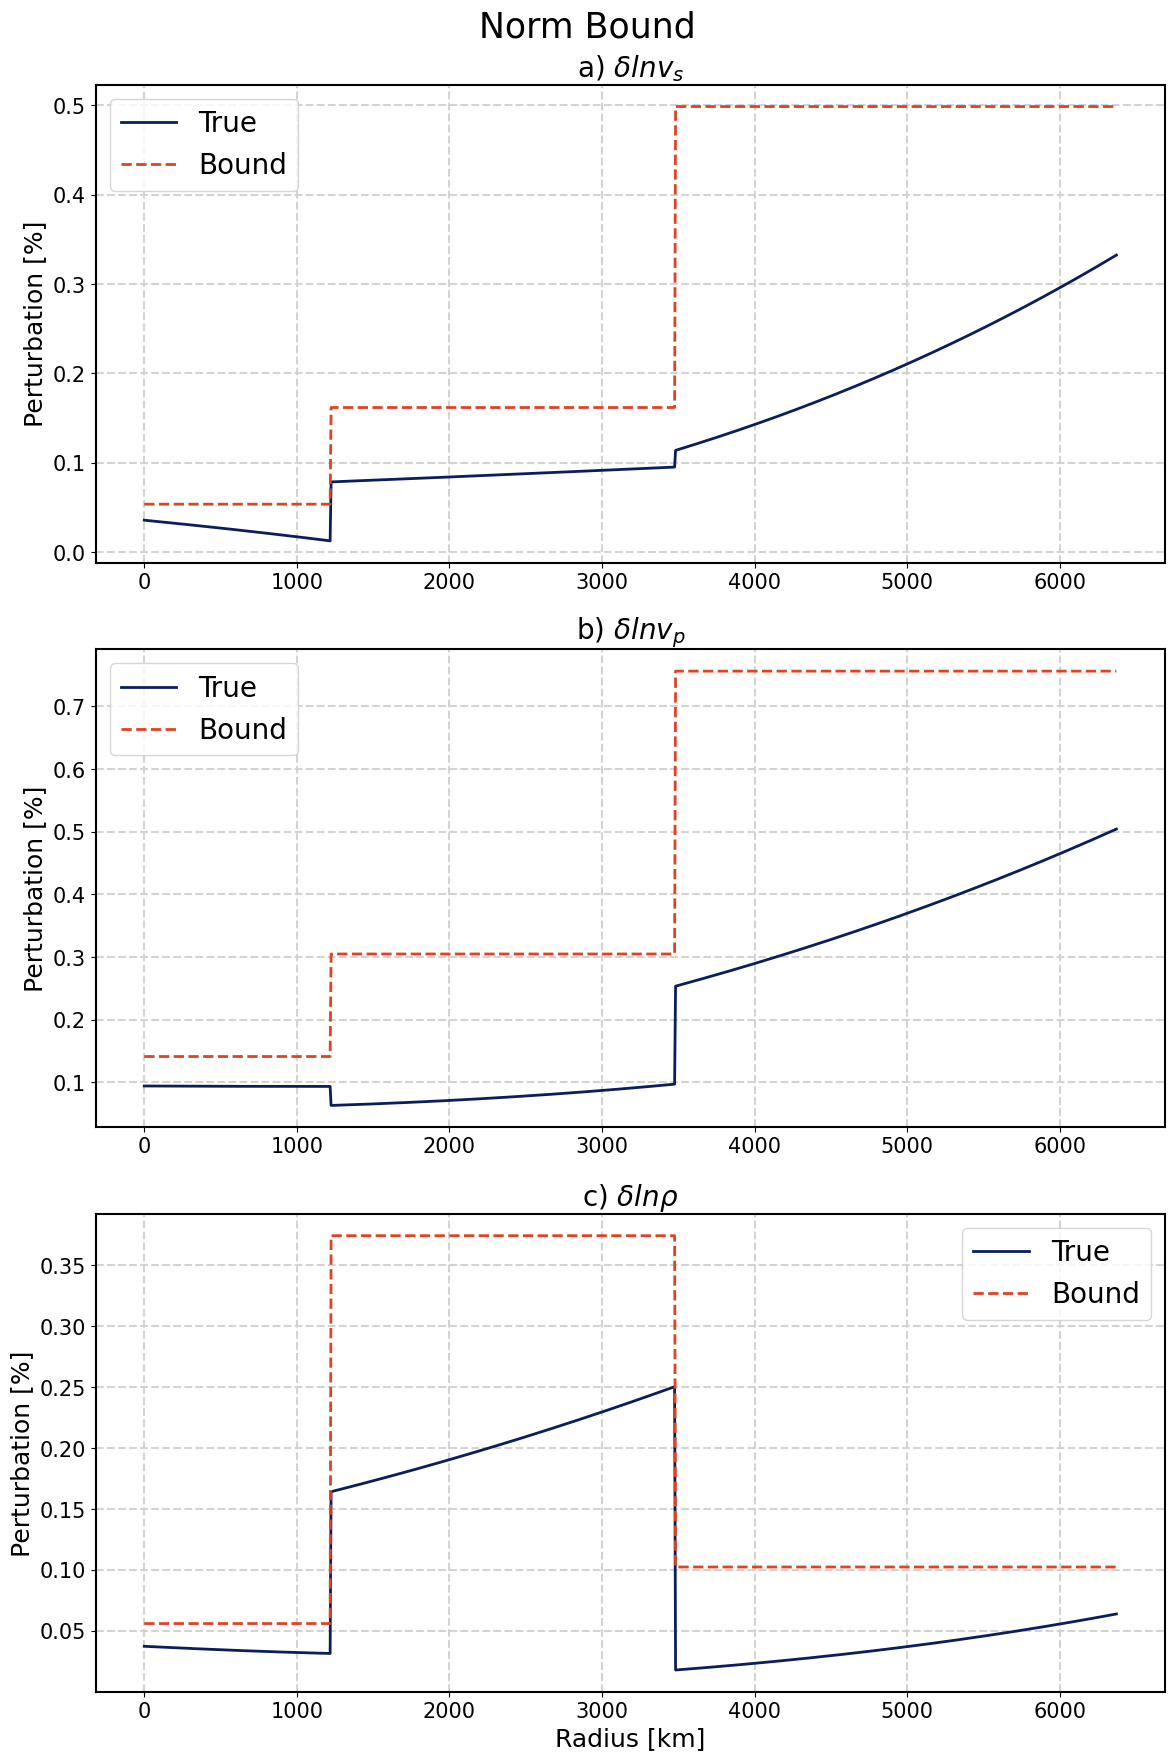

In [8]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,1220, 3480, EarthDomain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = [1.5*np.max(
                np.abs(
                model.evaluate(np.linspace(intervals[index],
                               intervals[index+1], 100)))) \
                for index in range(len(intervals) - 1)]
    upper_bound = functions.Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
    axes[i].plot(EarthDomain.mesh, np.abs(submodel.evaluate(EarthDomain.mesh)),
             label='True', color=colors[99], linewidth=2)
    axes[i].plot(EarthDomain.mesh, upperbound.evaluate(EarthDomain.mesh),
             label='Bound', color='#dd4423', linestyle='--', linewidth=2)
    # Set title and labels
    axes[i].set_title(labels[i] + physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_ylabel('Perturbation [%]', fontsize=18)
    # Set tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes[i].legend(fontsize=12)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
    axes[i].legend(fontsize=20)
plt.xlabel('Radius [km]', fontsize=18)
plt.suptitle('Norm Bound', fontsize=25)
plt.tight_layout()
plt.savefig('bound_normal.png', bbox_inches='tight')
plt.show()

Now with all the components at hand, we put them all in a "Problem" class instance

In [9]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

The Problem holds all the important parameters of our sola problem introduced by us, like the model space, model-data mappings, etc and many properties that have not been inputed but can be computed (like property bounds, resolving kernels, least norm property solution, etc). The various components that need to be computed to arrive at the solution of our problem are not connected in a linear fashion; that is, going from our initial mathematical object to the final solution is not a simple chain of computations. The problem instance of the Problem class has a dependency graph that shows how the various elements of a SOLA problem are related. 

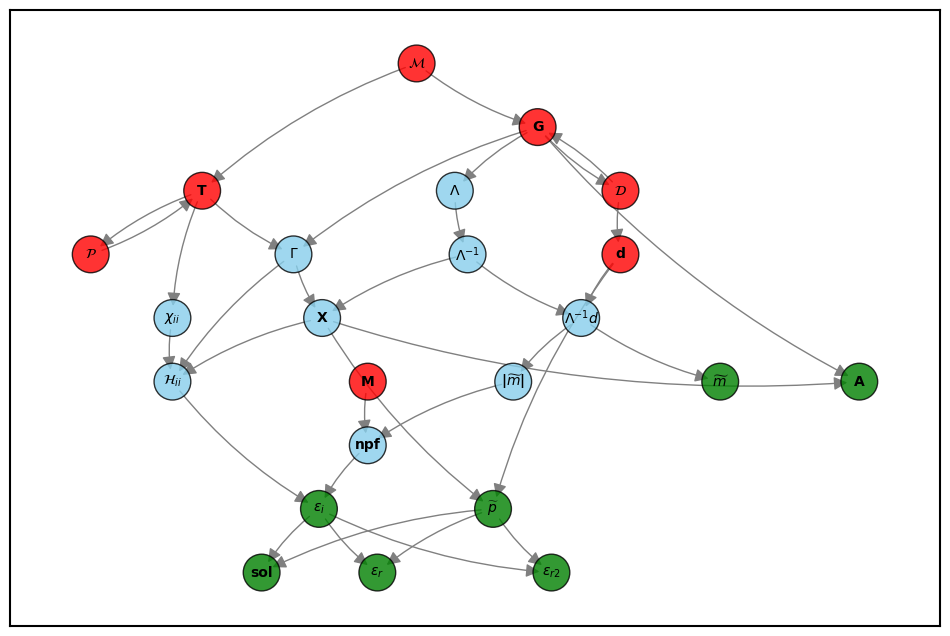

In [10]:
problem.dependencies.plot_dependency_tree()

The red blobs represent elements that we need to build ourselves before even trying to solve the problem (parenthesis - "alias" of the element):
1. $\mathcal{M}$ - Model space (model_space) 
2. $\mathcal{D}$ - Data space (data_space)
3. $\mathcal{P}$ - Property space (property_space)
4. G - Model-Data mapping (G)
5. T - Model-Property mapping (T)
6. d - Data (data)

These elements are normally the ones that we will modify as they define the problem to be solved. 

The green blobs are "end points" for our problem - things we might want to plot for example:

7. sol - Upper and lower bounds on the desired property (solution)
8. $\epsilon_i$ -  Property error bounds (epsilon)
9. A - Resolving kernels (A)
10. $\tilde{p}$ - Least norm property solution (least_norm_property)
11. $\tilde{m}$ - Least norm model solution (least_norm_solution)
12. $\epsilon_r$ - Relative errors obtained as $\epsilon_r = \epsilon/\tilde{p}$
13. $\epsilon_{r2}$ - Another version of relative errors as $\epsilon_{r2} = \epsilon/range(\tilde{p})$

The blue blobs are elements that need to be computed in order to arrive at some solution. Some of them are notably expensive/difficult to deal with such as $\Lambda$ and $\Lambda^{-1}$.

14. $\Lambda$ - The kernels Gram matrix (Lambda)
15. $\Lambda^{-1}$ - The kernels Gram matrix inverse (Lambda_inv)
16. $\Lambda^{-1}d$ - The "shuffled"/remapped data (sdata)
17. $\lVert \tilde{m} \rVert$ - Least norm (least_norm)
18. npf - Norm Prefactor, basically $\sqrt{M^2 - \lVert \tilde{m} \rVert^2}$ (npf) 
19. $\Gamma$ - Gamma (Gamma)
20. X - X (X)
21. $\chi_{ii}$ - Diagonal of the matrix containing $\int T_i T_j$ (chi)
22. $\mathcal{H}_{ii}$ - Diagonal of the H matrix (H)


Why did I make this tree? Because sometimes we might want to see how changing some parameters of the problem (red) leads to changes in some important quantities without recomputing everything again from scratch. Using this tree we can see, for example, that if we want to see the effect of changing the norm bound $M$ on the solution we only need to recompute the norm prefactor (npf) and the property error bounds ($\epsilon$). Or, if we only changed the target kernels (T) and want to see the changes in the resolving kernels (A) we only need to recompute Gamma and X. 

This tree is built into the "problem" class and it is being used to asses what needs to be recomputed when a particular element has been changed. 

Given some element of the problem - like resolving kernels A - you can also see what are the elements A depends on using the "find_dependent_nodes" method:

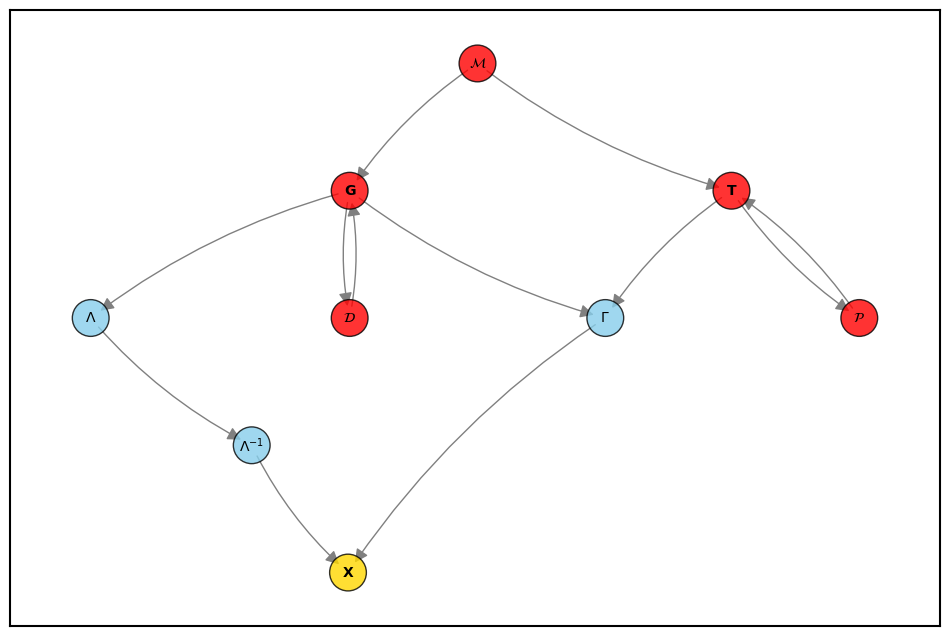

In [11]:
dependent_nodes = problem.dependencies.find_dependent_nodes('X', plot_dependent_tree=True)

We can also see what are all the elements affected (need recomputation) when changing another element

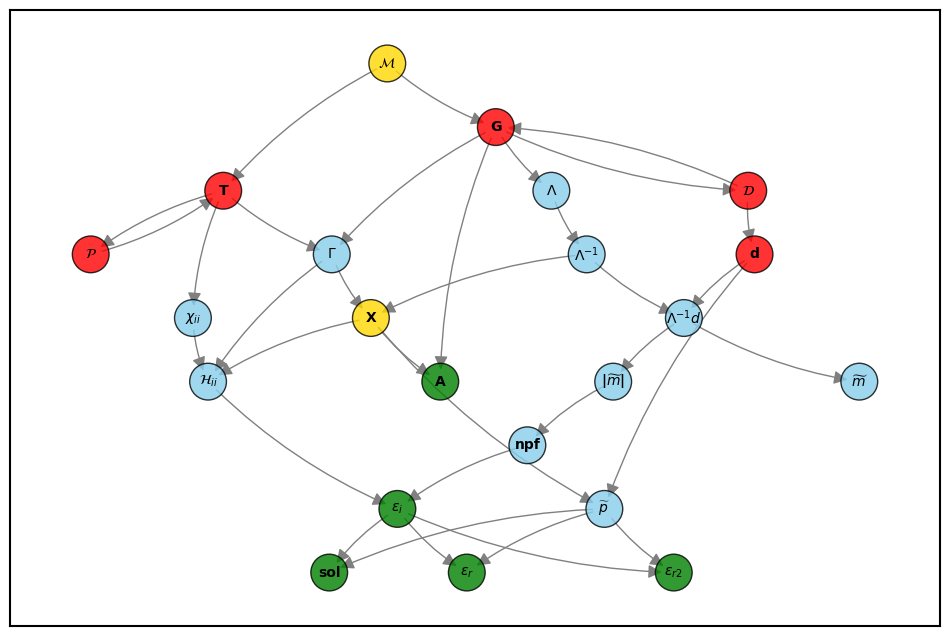

In [12]:
reacheable_nodes = problem.dependencies.find_reachable_nodes(['M', 'X'], plot_reachable_graph=True)

Now let's start solving the problem. This is easy, just do:

In [13]:
problem.solve()

In [14]:
problem._compute_least_norm_property()

In [15]:
# Compute True property
true_property = T.map(true_model)

In [16]:
print(problem.least_norm)
print(M.norm(true_model))
print(M.norm(upper_bounds))

25.78910003887191
43.46855853646743
90.13487687102378


With the problem solved, we will find the solution (property bounds) in "problem.solution" and we can plot it.

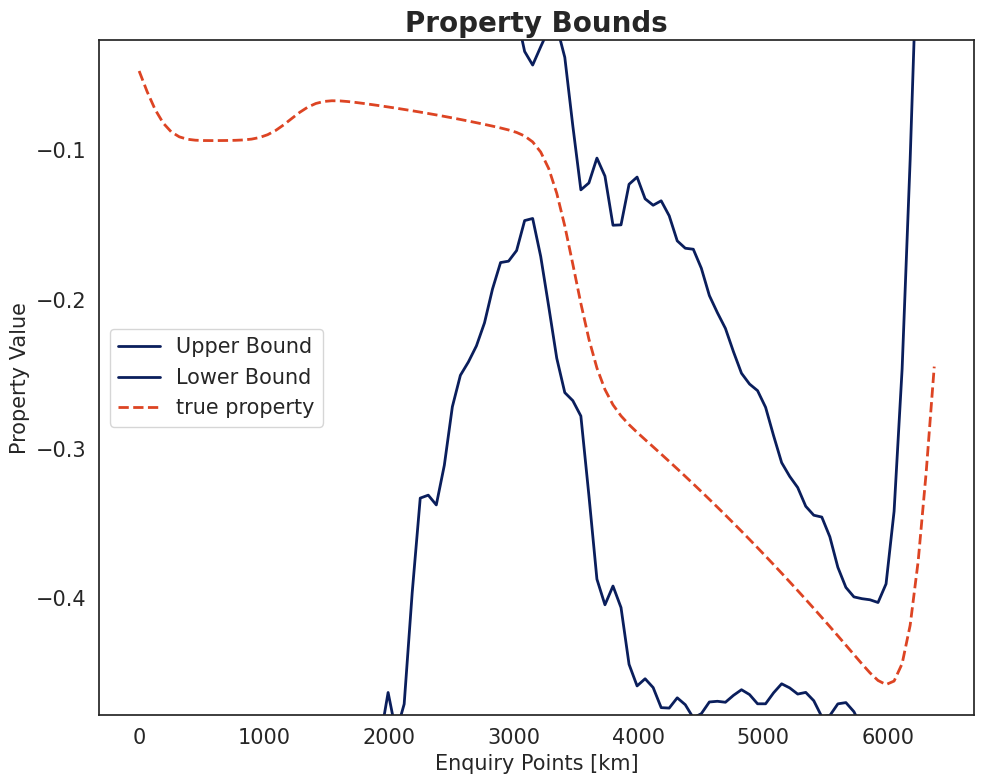

In [17]:
###############
# Plot solution
###############
# Find limits for y axis
y_max = np.max(true_property)
y_min = np.min(true_property)
y_center = (y_max + y_min) / 2
y_range = y_max - y_min
y_min = y_center - 1.1 * y_range / 2
y_max = y_center + 1.1 * y_range / 2
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
sns.set_theme(style='white')  # Set seaborn style
plt.title('Property Bounds', fontsize=20, fontweight='bold')  # Increase font size and add bold
plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[99],
         linewidth=2, label='Upper Bound')  # Increase line width
plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[99],
         linewidth=2, label='Lower Bound')  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423', linestyle='--',
         linewidth=2, label='true property')
#plt.fill_betweenx([y_min, y_max], 1220, 3480, color='gray', alpha=0.3, label='Outer Core')
plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(0, .5))

plt.xlabel('Enquiry Points [km]', fontsize=15)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=15)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('norm_solution.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

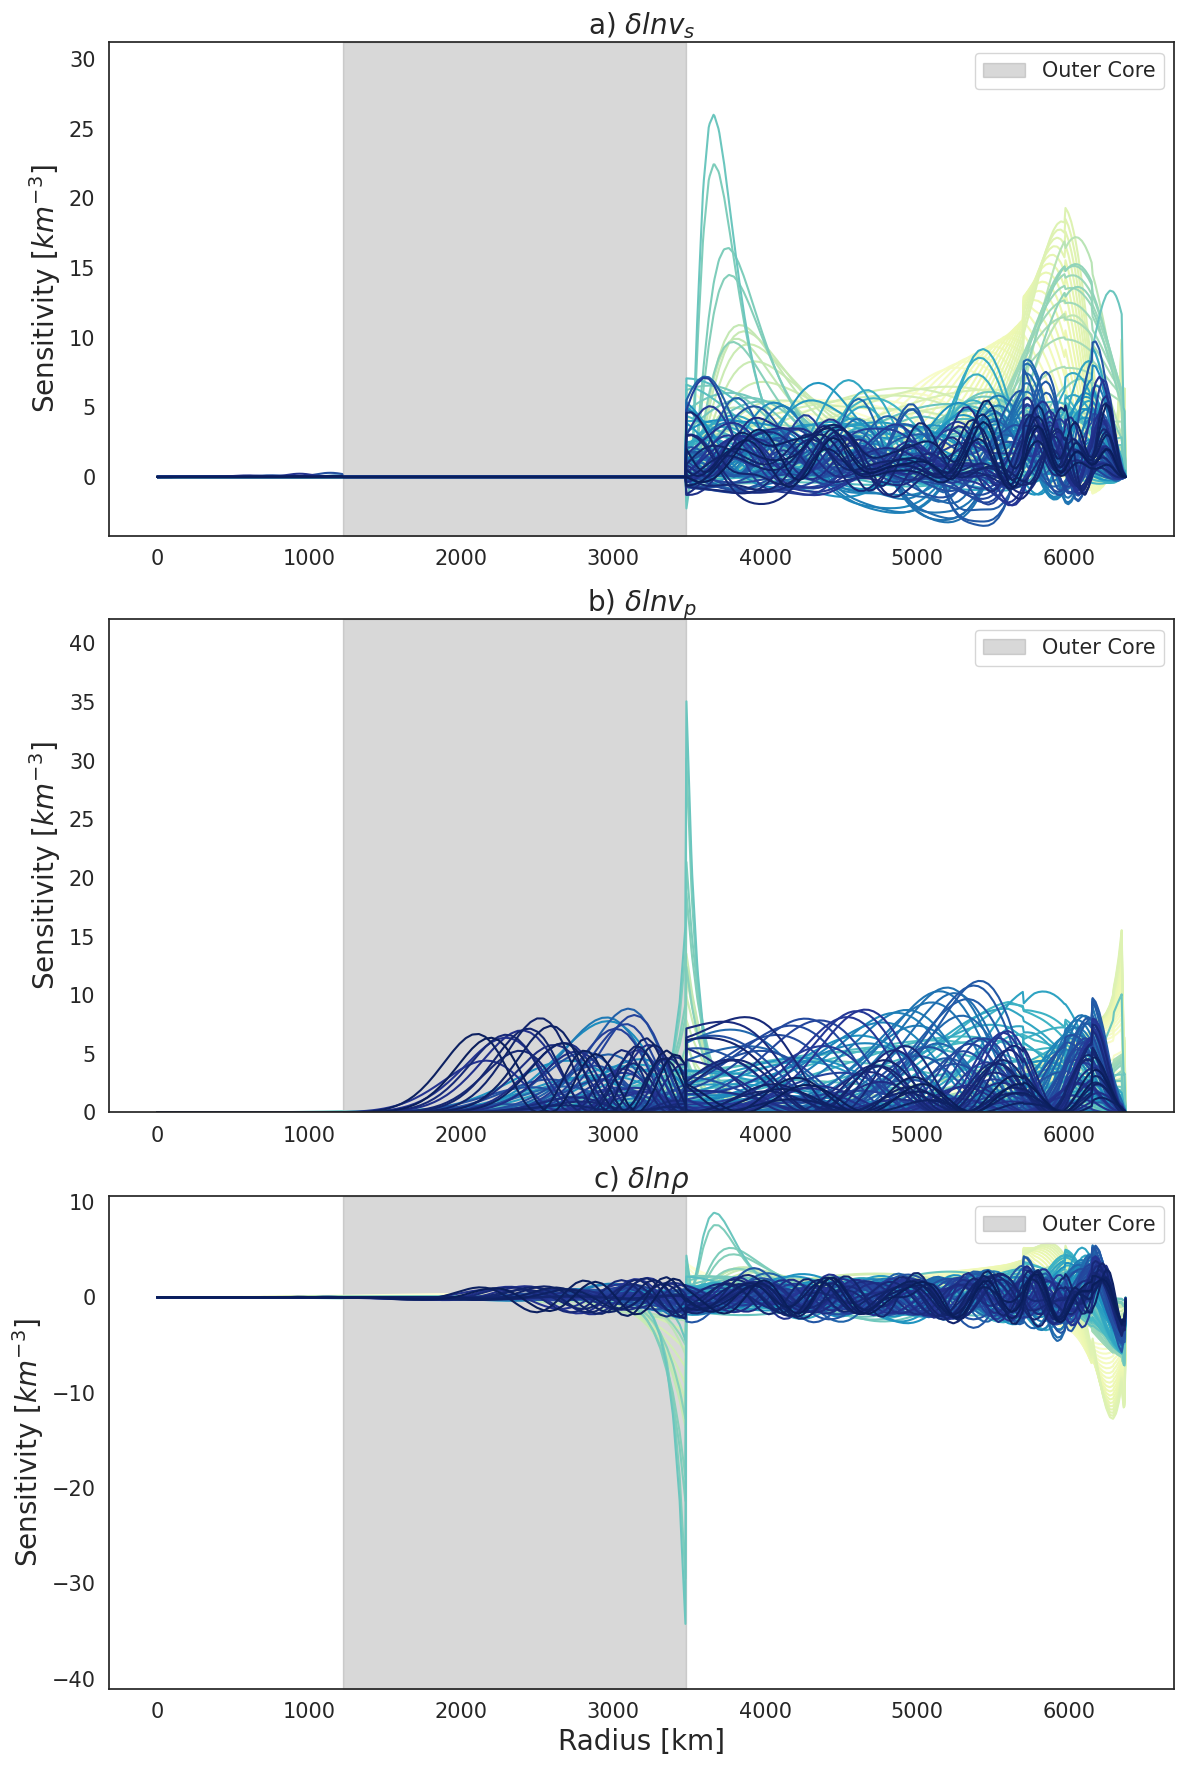

In [18]:
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))

for i, param in enumerate(physical_parameters):
    # Initialize y_min and y_max with extreme values to be updated dynamically
    y_min = float('inf')
    y_max = float('-inf')

    for j, kernel in enumerate(sensitivity_dict[param]):
        y_values = kernel.evaluate(EarthDomain.mesh)  # Extract y-values from the kernel data

        # Update y_min and y_max based on current kernel's data
        y_min = min(y_min, np.min(y_values))
        y_max = max(y_max, np.max(y_values))

        axes[i].plot(EarthDomain.mesh, y_values, color=colors[int(100*j/len(which_data))])
    y_min *= 1.2
    y_max *= 1.2
    axes[i].set_title(labels[i] + physical_parameters_symbols[param], fontsize=20)
    axes[i].set_ylabel('Sensitivity ' + r'[$km^{-3}$]', fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].set_ylim([y_min, y_max])
    # Fill between the dynamic y_min and y_max values
    axes[i].fill_betweenx([y_min, y_max], 1220, 3480, color='gray', alpha=0.3, label='Outer Core')

    # Add legend to the plot
    axes[i].legend(fontsize=15)

# Adjust fontsize for ticks
axes[i].set_xlabel('Radius [km]', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.suptitle(None, fontsize=25)
plt.tight_layout()
plt.savefig('Kernels_for_paper_normal' + '.png', bbox_inches='tight', dpi=300)


In [19]:
problem._compute_resolving_kernels()

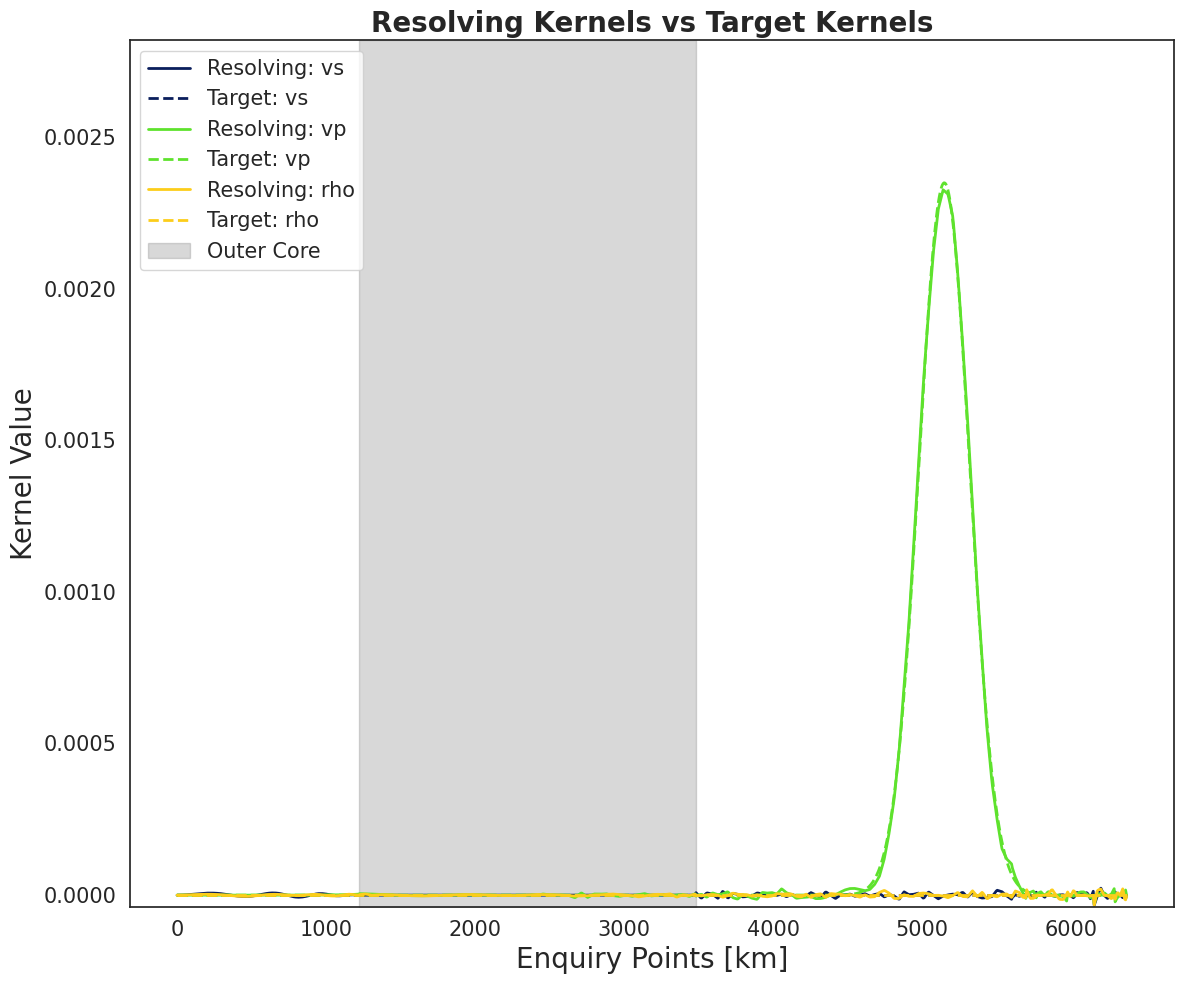

In [20]:
which_kernel = 80
param_color = dict(zip(physical_parameters, [colors[99], '#5ee22d', '#fccd1a']))
plt.figure(1, figsize=(12,10))

# Lists to store the y-values of all plotted data
all_y_values = []

for param, mapping in zip(physical_parameters, problem.A.mappings):
    # Plot resolving kernel
    resolving_kernel_y_values = mapping.kernels[which_kernel].evaluate(EarthDomain.mesh)
    plt.plot(EarthDomain.mesh, resolving_kernel_y_values,
             color=param_color[param], label='Resolving: ' + str(param), linewidth=2)
    all_y_values.extend(resolving_kernel_y_values)

    # Plot target kernel
    target_kernel_y_values = targets_dict[param][which_kernel].evaluate(EarthDomain.mesh)
    plt.plot(EarthDomain.mesh, target_kernel_y_values,
             linestyle='dashed', color=param_color[param], label='Target: ' + str(param), linewidth=2)
    all_y_values.extend(target_kernel_y_values)

# Calculate the minimum and maximum y-values from all the plotted data
y_min = min(all_y_values)*1.2
y_max = max(all_y_values)*1.2

# Fill between the specified y_min and y_max values
plt.fill_betweenx([y_min, y_max], 1220, 3480, color='gray', alpha=0.3, label='Outer Core')
plt.ylim([y_min, y_max])
plt.title('Resolving Kernels vs Target Kernels', fontsize=20, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Enquiry Points [km]', fontsize=20)
plt.ylabel('Kernel Value', fontsize=20)
plt.tight_layout()
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')
plt.savefig('resolving_kernel_' + str(which_kernel) + '.png', bbox_inches='tight', dpi=300)
plt.show()

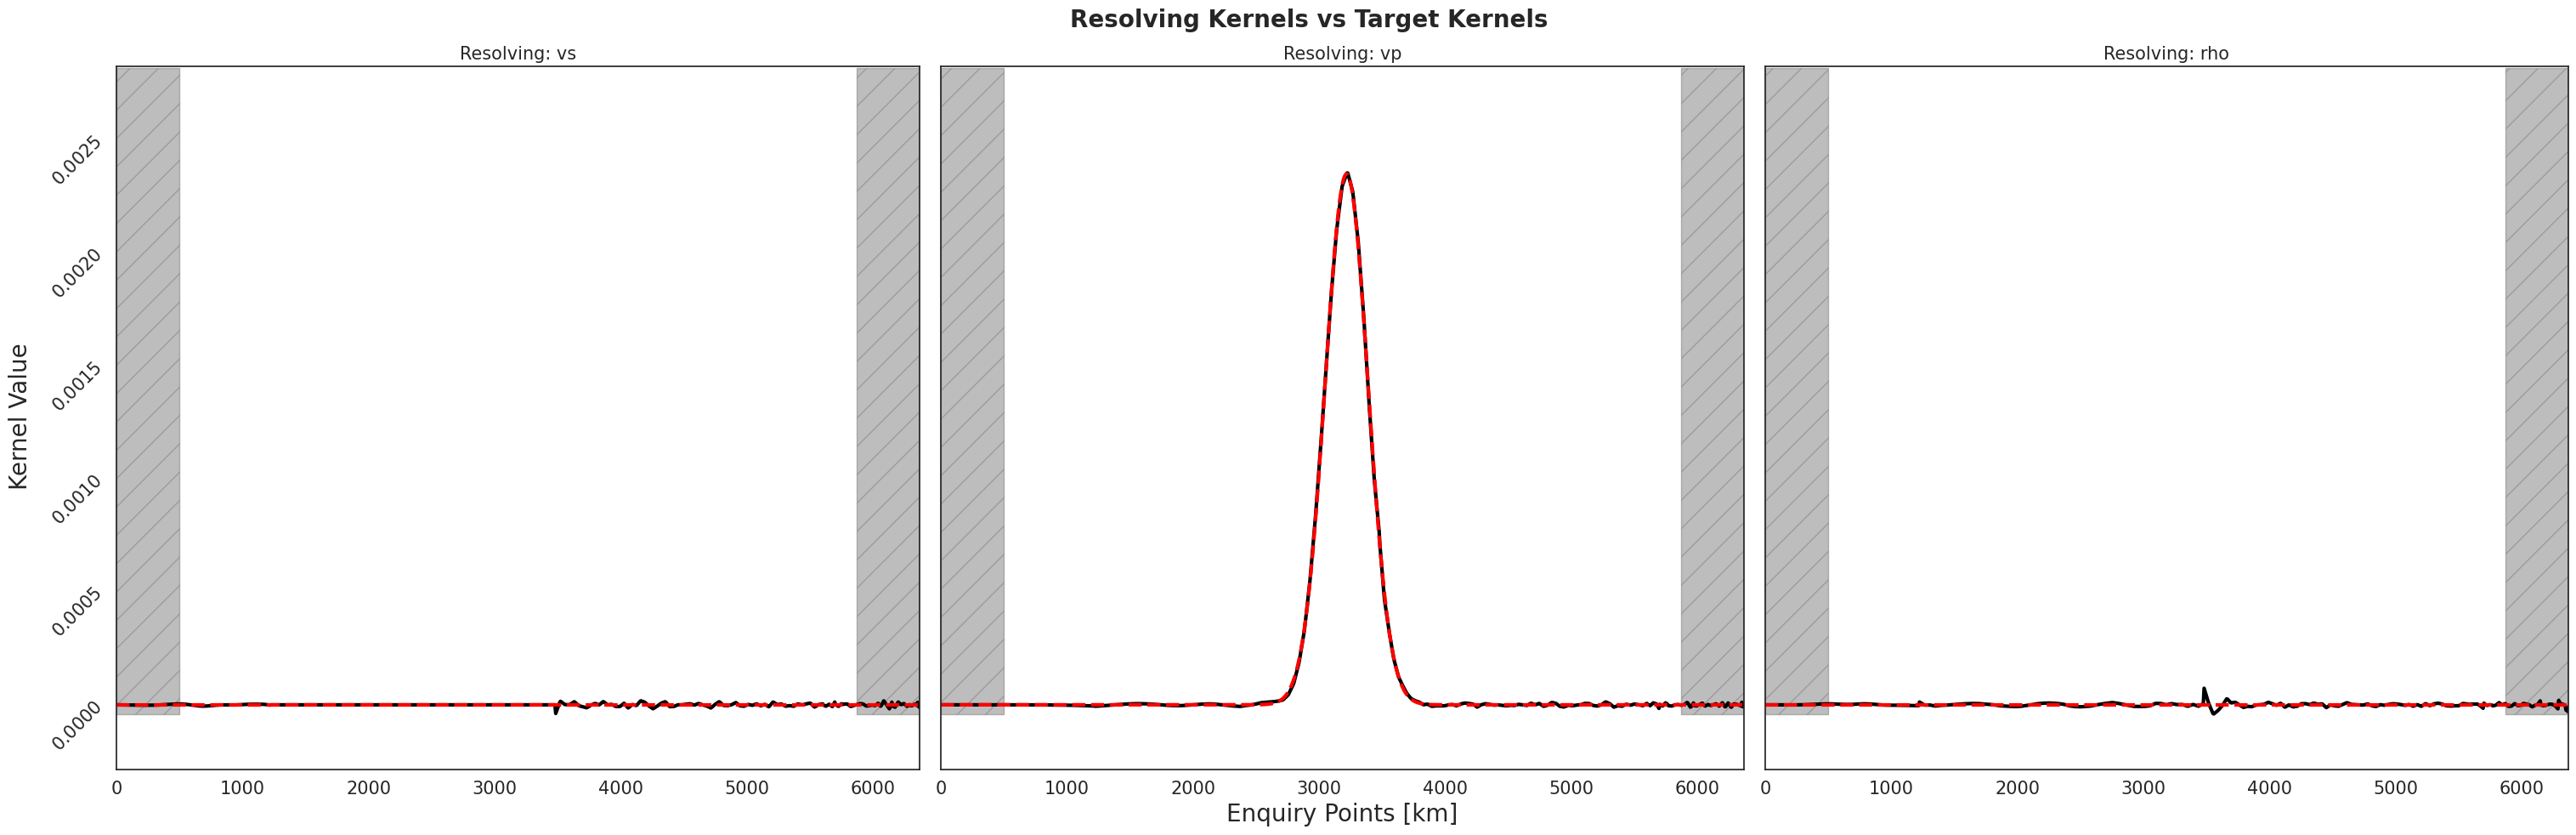

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Plot targets and resolving separately
which_kernel = 50
param_color = dict(zip(physical_parameters, [colors[99], '#5ee22d', '#fccd1a']))
fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)

# Lists to store the y-values of all plotted data
all_y_values = []

for index, (param, mapping) in enumerate(zip(physical_parameters, problem.A.mappings)):
    # Plot resolving kernel
    resolving_kernel_y_values = mapping.kernels[which_kernel].evaluate(EarthDomain.mesh)
    axes[index].plot(EarthDomain.mesh, resolving_kernel_y_values,
                        color='black', label='Resolving: ' + str(param), linewidth=3)
    all_y_values.extend(resolving_kernel_y_values)

    # Plot target kernel
    target_kernel_y_values = targets_dict[param][which_kernel].evaluate(EarthDomain.mesh)
    axes[index].plot(EarthDomain.mesh, target_kernel_y_values, linestyle='dashed',
                        color='red', label='Target: ' + str(param), linewidth=3)
    all_y_values.extend(target_kernel_y_values)
    axes[index].tick_params(axis='both', which='major', labelsize=15)
    axes[index].tick_params(axis='both', which='major', labelsize=15)

    # Set titles for each subplot
    axes[index].set_title('Target: ' + str(param), fontsize=15)
    axes[index].set_title('Resolving: ' + str(param), fontsize=15)

    axes[index].fill_betweenx([y_min, y_max], 0, width/2, color='gray', hatch='/', alpha=0.3, label='Uninterpretable \n region')
    axes[index].fill_betweenx([y_min, y_max], EarthDomain.bounds[0][1] - width/2, EarthDomain.bounds[0][1], color='gray', hatch='/', alpha=0.3)
    axes[index].fill_betweenx([y_min, y_max], 0, width/2, color='gray', hatch='/', alpha=0.3, label='Uninterpretable \n region')
    axes[index].fill_betweenx([y_min, y_max], EarthDomain.bounds[0][1] - width/2, EarthDomain.bounds[0][1], color='gray', hatch='/', alpha=0.3)

# Calculate the minimum and maximum y-values from all the plotted data
y_min = min(all_y_values) * 1.2
y_max = max(all_y_values) * 1.2

if (y_min < 0) and (np.abs(y_min) / (y_max - y_min) < 0.1):
    y_min = -(y_max - y_min)*0.1

# Fill between the specified y_min and y_max values
plt.ylim([y_min, y_max])
plt.xlim([EarthDomain.bounds[0][0], EarthDomain.bounds[0][1]])
plt.suptitle('Resolving Kernels vs Target Kernels', fontsize=20, fontweight='bold')
plt.subplots_adjust(top=0.9)  # Adjust the top space for the suptitle

axes[1].set_xlabel('Enquiry Points [km]', fontsize=20)
fig.text(-0.01, 0.5, 'Kernel Value', va='center', rotation='vertical', fontsize=20)  # Adjusted y-label position

# Rotate y-tick labels diagonally and use scientific notation
for ax in axes.flat:
    ax.tick_params(axis='y', labelrotation=45)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()

# Save and show the plot
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')
plt.savefig('resolving_kernel_' + str(targets_dict['vp'][which_kernel]) + '_' + str(which_kernel) + '_' + str(width) + '.png', bbox_inches='tight', dpi=300)
plt.show()


In [22]:
problem._compute_least_norm_solution()

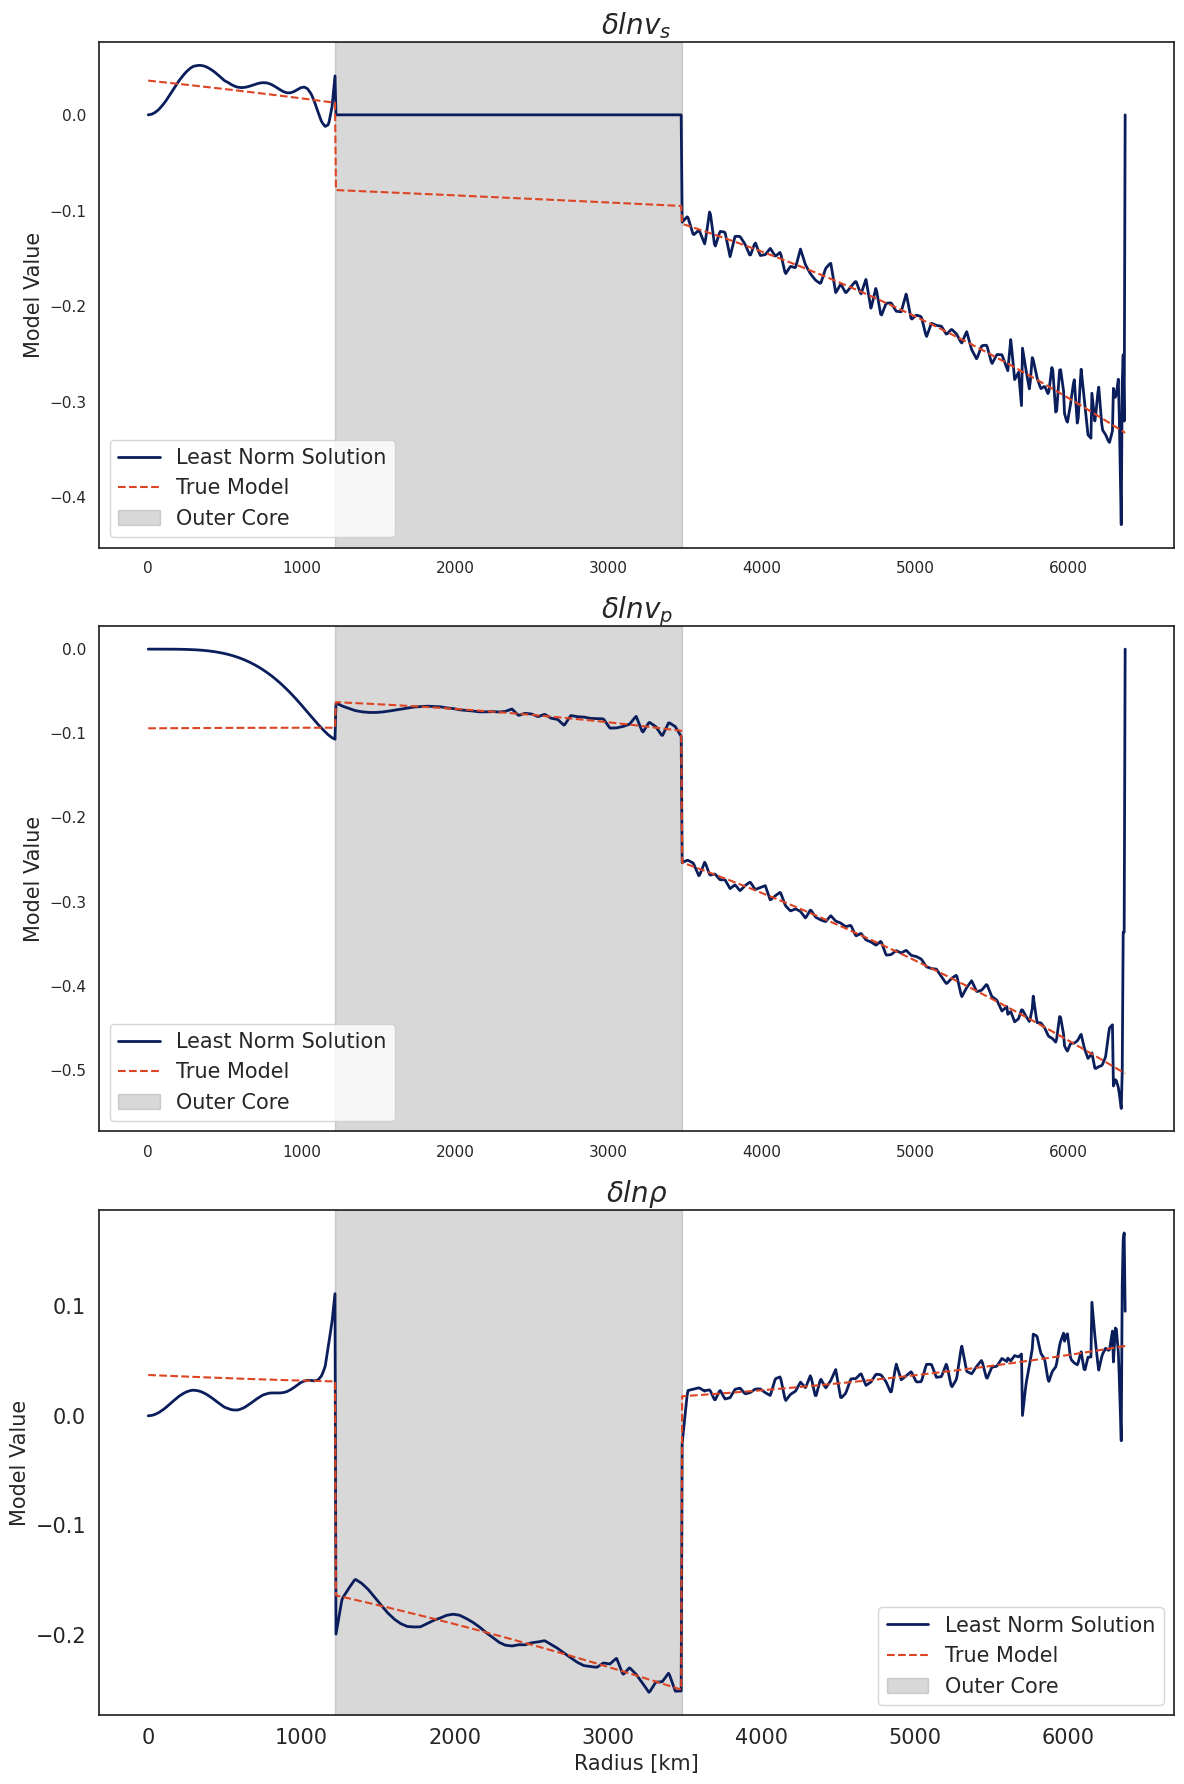

In [23]:
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))
for i, physical_parameter in enumerate(physical_parameters):
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)  # Increase font size and add bold
    axes[i].plot(EarthDomain.mesh, problem.least_norm_solution[i].evaluate(EarthDomain.mesh),
            color=colors[99], linewidth=2, label='Least Norm Solution')  # Increase line width
    axes[i].plot(EarthDomain.mesh, true_model[i].evaluate(EarthDomain.mesh),
                 color='#dd4423', linestyle='dashed', label='True Model')
    axes[i].set_ylabel('Model Value', fontsize=15)  # Add Y-axis label with fontsize
    y_min, y_max = axes[i].get_ylim()
    axes[i].fill_betweenx([y_min, y_max], 1220, 3480, color='gray', alpha=0.3, label='Outer Core')
    axes[i].set_ylim([y_min, y_max])
    axes[i].legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Radius [km]', fontsize=15)  # Add X-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()